# Antiques Watches 

<img style="float: left; width: 300px;  height : 200px" src="data/antique_watches.jpg"> 

The following dataset contains price and age of different watches. <br /> 
Goal will be to build a simple linear regression model in order to predict the price of a watch based on its age. <br /> I'm going to fit two regression models using scikit-learn and tensorflow to compare the results to each other.

## Import dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import datasets, linear_model
import pandas as pd
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

## Read & Describing Data

In [2]:
df = pd.read_csv("data/antique_watches.csv", sep=";", dtype=float); 
df.describe()

,age,price
count,32.000000,32.000000
mean,144.937500,1327.156250
std,27.395476,393.134395
min,108.000000,729.000000
25%,117.000000,1053.000000
50%,140.000000,1257.500000
75%,168.500000,1560.750000
max,194.000000,2131.000000


The range of values for age and price is relatively wide and without rescaling the values it might be possible that our gradient descent optimizer in TensorFlow will not work properly. There are a lot of techniques to rescale the data, I will just bring the values of both columns in a range of [0,1] by applying the following formula:  <br /> 

$ x' = \frac{x-min(x)}{max(x) - min(x)} $ <br />  

where x is the variable to be rescaled

### Rescaling Data

In [3]:
def rescaling(x):
    return(x-np.min(x)) / (np.max(x) - np.min(x))

scaled_price = np.asarray(rescaling(df.price))
scaled_age = np.asarray(rescaling(df.age))

df = pd.concat([df, pd.DataFrame({'scaled_age': scaled_age, 'scaled_price': scaled_price})], 
               axis=1)
df.describe()

,age,price,scaled_age,scaled_price
count,32.000000,32.000000,32.000000,32.000000
mean,144.937500,1327.156250,0.429506,0.426645
std,27.395476,393.134395,0.318552,0.280410
min,108.000000,729.000000,0.000000,0.000000
25%,117.000000,1053.000000,0.104651,0.231098
50%,140.000000,1257.500000,0.372093,0.376961
75%,168.500000,1560.750000,0.703488,0.593260
max,194.000000,2131.000000,1.000000,1.000000


### Plots

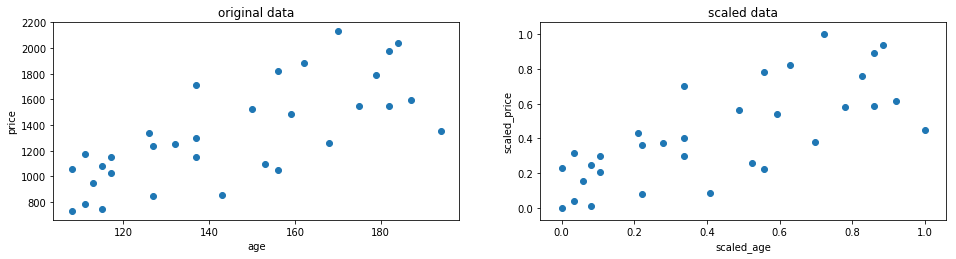

In [4]:
plt.figure(1, figsize=(16,8))

# linear
plt.subplot(221)
plt.scatter(x=df.age, y=df.price)
plt.title('original data')
plt.xlabel('age')
plt.ylabel('price')
plt.grid(False)


# scaled data
plt.subplot(222)
plt.scatter(x = df.scaled_age, y = df.scaled_price)
plt.title('scaled data')
plt.xlabel('scaled_age')
plt.ylabel('scaled_price')
plt.grid(False)

## Scikit-learn model

In [5]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [6]:
x_train = df.scaled_age.values.reshape(-1,1)
y_train = df.scaled_price.values.reshape(-1,1)
regr.fit(x_train, y_train)

/Users/enzo/tensorflow-tutorials/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [7]:
# The coefficients
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

Coefficients: 
 [[ 0.64279755]]
Intercept: 
 [ 0.15055969]


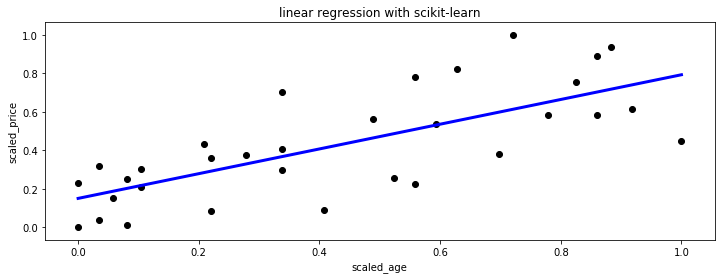

In [8]:
# Plot outputs
plt.figure(1, figsize=(12,4))
plt.scatter(x_train, y_train,  color='black')
plt.plot(x_train, regr.predict(x_train), color='blue',linewidth=3)
plt.title('linear regression with scikit-learn')
plt.xlabel('scaled_age')
plt.ylabel('scaled_price')
plt.show()

## TensorFlow

### Setup Variables and linear regression model

In [9]:
W = tf.Variable(tf.zeros([1]))
b = tf.Variable(tf.zeros([1]))
y = W * np.asarray(df.scaled_age) + b

### Define cost function and gradient descent optimizer

In [10]:
loss = tf.reduce_mean(tf.square(y - np.asarray(df.scaled_price)))
optimizer = tf.train.GradientDescentOptimizer(0.001)
train = optimizer.minimize(loss)

### Initializing the variables and run session

In [11]:
# initializing the variables
init = tf.global_variables_initializer()

# starting the session session 
sess = tf.Session()
sess.run(init)

In [12]:
# training the line
for step in range(30000):
    sess.run(train)

print("Model paramters:")
print("Weight:%f" %sess.run(W))
print("bias:%f" %sess.run(b))

Model paramters:
Weight:0.639339
bias:0.152179


### Result

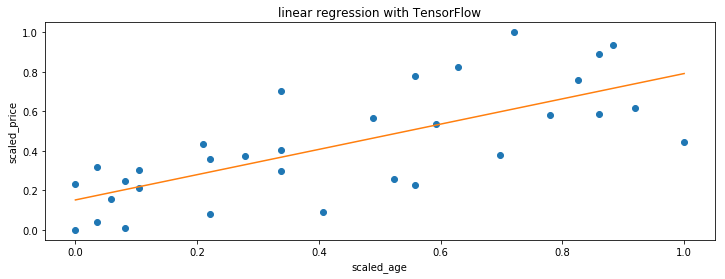

In [13]:
x_test = df.scaled_age
y_test = sess.run(W) * x_test + sess.run(b)

plt.figure(1, figsize=(12,4))
plt.plot(df.scaled_age, df.scaled_price,'o', x_test, y_test)
plt.title('linear regression with TensorFlow')
plt.xlabel('scaled_age')
plt.ylabel('scaled_price')
plt.show()

## Summary

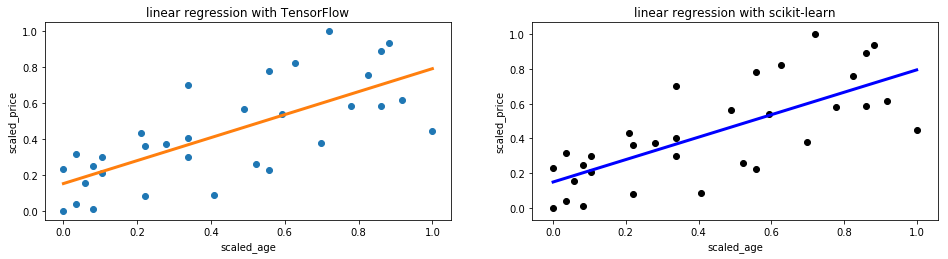

In [14]:
plt.figure(1, figsize=(16,8))

# TensorFlow
plt.subplot(221)
plt.figure(1, figsize=(12,4))
plt.plot(df.scaled_age, df.scaled_price,'o', x_test, y_test, linewidth=3)
plt.title('linear regression with TensorFlow')
plt.xlabel('scaled_age')
plt.ylabel('scaled_price')


# scikit-learn
plt.subplot(222)
plt.figure(1, figsize=(12,4))
plt.scatter(x_train, y_train,  color='black')
plt.plot(x_train, regr.predict(x_train), color='blue',linewidth=3)
plt.title('linear regression with scikit-learn')
plt.xlabel('scaled_age')
plt.ylabel('scaled_price')

|                      | TensorFlow | scikit-learn linear regression |
|----------------------|------------|--------------------------------|
| Weight (Coefficient) |  0.639339  |           0.64279755           |
| bias (Intercept)     |  0.152179  |           0.15055969           |